In [15]:
import os
import re

import cv2
import math
import numpy as np
import scipy as sp
import pandas as pd

import tensorflow as tf
from IPython.display import SVG
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet121

import seaborn as sns
from tqdm import tqdm
import matplotlib.cm as cm
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
tqdm.pandas()

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

np.random.seed(0)

import warnings
warnings.filterwarnings("ignore")

In [16]:
#Read Images & Setting Paths
EPOCHS = 300
SAMPLE_LEN = 100
IMAGE_PATH = "./plant-pathology-2020-fgvc7/images/"
TEST_PATH = "./plant-pathology-2020-fgvc7/test.csv"
TRAIN_PATH = "./plant-pathology-2020-fgvc7/train.csv"
SUB_PATH = "./plant-pathology-2020-fgvc7/sample_submission.csv"

sub = pd.read_csv(SUB_PATH)
test_data = pd.read_csv(TEST_PATH)
train_data = pd.read_csv(TRAIN_PATH)

In [17]:
train_data.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [18]:
#Setting Test and Train
def format_path(st):
    return './plant-pathology-2020-fgvc7' + '/images/' + st + '.jpg'

test_paths = test_data.image_id.apply(format_path).values
train_paths = train_data.image_id.apply(format_path).values

train_labels = np.float32(train_data.loc[:, 'healthy':'scab'].values)
train_paths, valid_paths, train_labels, valid_labels = train_test_split(train_paths, train_labels, 
                                                                        test_size=0.15, random_state=2020)

### CNN

In [5]:
#Default Values for the CNN Model
img_size = 112
def decode_image(filename, label=None, image_size=(img_size, img_size)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, image_size)
    
    if label is None:
        return image
    else:
        return image, label

def data_augment(image, label=None):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if label is None:
        return image
    else:
        return image, label

In [6]:
reg = .0005
BATCH_SIZE = 24

In [7]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_paths, train_labels))
    .map(decode_image)
    .map(data_augment)
    .repeat()
    .shuffle(512)
    .batch(BATCH_SIZE))

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((valid_paths, valid_labels))
    .map(decode_image)
    .batch(BATCH_SIZE)
    .cache())


In [8]:
STEPS_PER_EPOCH = train_labels.shape[0] // BATCH_SIZE
STEPS_PER_EPOCH

64

In [10]:
#CNN Model Body
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(32, kernel_size=(3,3),activation='relu', input_shape=(img_size, img_size, 3), 
                                 kernel_regularizer=tf.keras.regularizers.l2(reg)))
model.add(tf.keras.layers.BatchNormalization(axis=-1,center=True,scale=False))
model.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3),activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg)))
model.add(tf.keras.layers.BatchNormalization(axis=-1,center=True,scale=False))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), padding='SAME'))
model.add(tf.keras.layers.Dropout(.25))

model.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3),activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg)))
model.add(tf.keras.layers.BatchNormalization(axis=-1,center=True,scale=False))
model.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg)))
model.add(tf.keras.layers.BatchNormalization(axis=-1,center=True,scale=False))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), padding='SAME'))
model.add(tf.keras.layers.Dropout(.25))

model.add(tf.keras.layers.Conv2D(128, kernel_size=(5,5),activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg)))
model.add(tf.keras.layers.BatchNormalization(axis=-1,center=True,scale=False))
model.add(tf.keras.layers.Conv2D(256, kernel_size=(5,5),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg)))
model.add(tf.keras.layers.BatchNormalization(axis=-1,center=True,scale=False))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), padding='SAME'))
model.add(tf.keras.layers.Dropout(.25))

model.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg)))
model.add(tf.keras.layers.BatchNormalization(axis=-1,center=True,scale=False))
model.add(tf.keras.layers.Conv2D(512, kernel_size=(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg)))
model.add(tf.keras.layers.BatchNormalization(axis=-1,center=True,scale=False))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), padding='SAME'))
model.add(tf.keras.layers.Dropout(.25))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(200,activation='relu'))
model.add(tf.keras.layers.BatchNormalization(axis=-1,center=True,scale=False))
model.add(tf.keras.layers.Dropout(.1))
model.add(tf.keras.layers.Dense(64,activation='relu'))
model.add(tf.keras.layers.BatchNormalization(axis=-1,center=True,scale=False))
model.add(tf.keras.layers.Dropout(.1))
model.add(tf.keras.layers.Dense(4,activation='softmax'))
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 110, 110, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 110, 110, 32)      96        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 108, 108, 128)     36992     
_________________________________________________________________
batch_normalization_1 (Batch (None, 108, 108, 128)     384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 54, 54, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 54, 54, 128)       0         
____

In [11]:
LR_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=.5, patience=10, min_lr=.000001, verbose=1)

In [12]:
#Runing the Model
history = model.fit(train_dataset, epochs=300, validation_data=valid_dataset,
                    verbose=1, steps_per_epoch = STEPS_PER_EPOCH, callbacks=[LR_reduce])

Epoch 1/300
64/64 [==============================] - 52s 805ms/step - loss: 2.0127 - acc: 0.4049 - val_loss: 4.8023 - val_acc: 0.0474
Epoch 2/300
64/64 [==============================] - 39s 609ms/step - loss: 1.8072 - acc: 0.4414 - val_loss: 3.5006 - val_acc: 0.3431
Epoch 3/300
64/64 [==============================] - 39s 605ms/step - loss: 1.7655 - acc: 0.4701 - val_loss: 2.2781 - val_acc: 0.3358
Epoch 4/300
64/64 [==============================] - 39s 615ms/step - loss: 1.6478 - acc: 0.5104 - val_loss: 4.5739 - val_acc: 0.3431
Epoch 5/300
64/64 [==============================] - 39s 611ms/step - loss: 1.4968 - acc: 0.5931 - val_loss: 3.2656 - val_acc: 0.2847
Epoch 6/300
64/64 [==============================] - 38s 601ms/step - loss: 1.3256 - acc: 0.6868 - val_loss: 3.7463 - val_acc: 0.3431
Epoch 7/300
64/64 [==============================] - 39s 605ms/step - loss: 1.1715 - acc: 0.7533 - val_loss: 3.6217 - val_acc: 0.4270
Epoch 8/300
64/64 [==============================] - 38s 601ms

64/64 [==============================] - 39s 611ms/step - loss: 0.6454 - acc: 0.8952 - val_loss: 1.2463 - val_acc: 0.6204
Epoch 24/300
64/64 [==============================] - 39s 603ms/step - loss: 0.6117 - acc: 0.8952 - val_loss: 1.0413 - val_acc: 0.7737
Epoch 25/300
64/64 [==============================] - 39s 602ms/step - loss: 0.5737 - acc: 0.9128 - val_loss: 0.9270 - val_acc: 0.8248
Epoch 26/300
64/64 [==============================] - 39s 608ms/step - loss: 0.5794 - acc: 0.9030 - val_loss: 2.0605 - val_acc: 0.5693
Epoch 27/300
64/64 [==============================] - 38s 601ms/step - loss: 0.5999 - acc: 0.9010 - val_loss: 0.9350 - val_acc: 0.7190
Epoch 28/300
64/64 [==============================] - 38s 601ms/step - loss: 0.5697 - acc: 0.9030 - val_loss: 1.1208 - val_acc: 0.7117
Epoch 29/300
64/64 [==============================] - 39s 602ms/step - loss: 0.5074 - acc: 0.9232 - val_loss: 1.0928 - val_acc: 0.6971
Epoch 30/300
64/64 [==============================] - 39s 603ms/step

64/64 [==============================] - 38s 601ms/step - loss: 0.3737 - acc: 0.9238 - val_loss: 0.7368 - val_acc: 0.7993
Epoch 69/300
64/64 [==============================] - 39s 604ms/step - loss: 0.3855 - acc: 0.9232 - val_loss: 0.8692 - val_acc: 0.6861
Epoch 70/300
64/64 [==============================] - 39s 603ms/step - loss: 0.3559 - acc: 0.9303 - val_loss: 0.7181 - val_acc: 0.8212
Epoch 71/300
64/64 [==============================] - 39s 602ms/step - loss: 0.4007 - acc: 0.9238 - val_loss: 1.5866 - val_acc: 0.6861
Epoch 72/300
64/64 [==============================] - 39s 604ms/step - loss: 0.3177 - acc: 0.9512 - val_loss: 0.5951 - val_acc: 0.8540
Epoch 73/300
64/64 [==============================] - 39s 608ms/step - loss: 0.4084 - acc: 0.9251 - val_loss: 0.8516 - val_acc: 0.7956
Epoch 74/300
64/64 [==============================] - 39s 603ms/step - loss: 0.3512 - acc: 0.9395 - val_loss: 0.4960 - val_acc: 0.8978
Epoch 75/300
64/64 [==============================] - 39s 603ms/step

64/64 [==============================] - 39s 608ms/step - loss: 0.3887 - acc: 0.9290 - val_loss: 0.9654 - val_acc: 0.7956
Epoch 114/300
64/64 [==============================] - 39s 602ms/step - loss: 0.4301 - acc: 0.9323 - val_loss: 0.6453 - val_acc: 0.8613
Epoch 115/300
64/64 [==============================] - 39s 603ms/step - loss: 0.3708 - acc: 0.9466 - val_loss: 0.7998 - val_acc: 0.8029
Epoch 116/300
64/64 [==============================] - 39s 603ms/step - loss: 0.3771 - acc: 0.9421 - val_loss: 1.2443 - val_acc: 0.6460
Epoch 117/300
64/64 [==============================] - 39s 602ms/step - loss: 0.3867 - acc: 0.9440 - val_loss: 0.8662 - val_acc: 0.7737
Epoch 118/300
64/64 [==============================] - 39s 603ms/step - loss: 0.3632 - acc: 0.9388 - val_loss: 1.2165 - val_acc: 0.6898
Epoch 119/300
64/64 [==============================] - 39s 603ms/step - loss: 0.4190 - acc: 0.9284 - val_loss: 1.7923 - val_acc: 0.5730
Epoch 120/300
64/64 [==============================] - 39s 602

64/64 [==============================] - 39s 605ms/step - loss: 0.3648 - acc: 0.9479 - val_loss: 1.9827 - val_acc: 0.5803
Epoch 159/300
64/64 [==============================] - 39s 605ms/step - loss: 0.3424 - acc: 0.9473 - val_loss: 0.6824 - val_acc: 0.8431
Epoch 160/300
64/64 [==============================] - 39s 611ms/step - loss: 0.3455 - acc: 0.9570 - val_loss: 0.5421 - val_acc: 0.9197
Epoch 161/300
64/64 [==============================] - 39s 606ms/step - loss: 0.3624 - acc: 0.9479 - val_loss: 0.7644 - val_acc: 0.8029
Epoch 162/300
64/64 [==============================] - 39s 606ms/step - loss: 0.4055 - acc: 0.9408 - val_loss: 0.4894 - val_acc: 0.9051
Epoch 163/300
64/64 [==============================] - 39s 606ms/step - loss: 0.3742 - acc: 0.9447 - val_loss: 0.6129 - val_acc: 0.8723
Epoch 164/300
64/64 [==============================] - 39s 605ms/step - loss: 0.3849 - acc: 0.9473 - val_loss: 0.9654 - val_acc: 0.6314
Epoch 165/300
64/64 [==============================] - 39s 605

64/64 [==============================] - 39s 604ms/step - loss: 0.3762 - acc: 0.9486 - val_loss: 0.6049 - val_acc: 0.9197
Epoch 204/300
64/64 [==============================] - 39s 603ms/step - loss: 0.3493 - acc: 0.9590 - val_loss: 0.5217 - val_acc: 0.9051
Epoch 205/300
64/64 [==============================] - 39s 602ms/step - loss: 0.3139 - acc: 0.9635 - val_loss: 0.4733 - val_acc: 0.9234
Epoch 206/300
64/64 [==============================] - 39s 603ms/step - loss: 0.3644 - acc: 0.9479 - val_loss: 0.7886 - val_acc: 0.8358
Epoch 207/300
64/64 [==============================] - 39s 605ms/step - loss: 0.4036 - acc: 0.9473 - val_loss: 0.6001 - val_acc: 0.9015
Epoch 208/300
64/64 [==============================] - 39s 609ms/step - loss: 0.4015 - acc: 0.9512 - val_loss: 0.5281 - val_acc: 0.9088
Epoch 209/300
64/64 [==============================] - 39s 604ms/step - loss: 0.3238 - acc: 0.9648 - val_loss: 0.7423 - val_acc: 0.8650
Epoch 210/300
64/64 [==============================] - 39s 603

64/64 [==============================] - 39s 603ms/step - loss: 0.3490 - acc: 0.9531 - val_loss: 0.5061 - val_acc: 0.9015
Epoch 249/300
64/64 [==============================] - 39s 603ms/step - loss: 0.3322 - acc: 0.9622 - val_loss: 0.5487 - val_acc: 0.8869
Epoch 250/300
64/64 [==============================] - 39s 604ms/step - loss: 0.3202 - acc: 0.9668 - val_loss: 0.7160 - val_acc: 0.8139
Epoch 251/300
64/64 [==============================] - 39s 605ms/step - loss: 0.3100 - acc: 0.9629 - val_loss: 0.6527 - val_acc: 0.8650
Epoch 252/300
64/64 [==============================] - 39s 605ms/step - loss: 0.3844 - acc: 0.9486 - val_loss: 1.3931 - val_acc: 0.7409
Epoch 253/300
64/64 [==============================] - 39s 603ms/step - loss: 0.3622 - acc: 0.9518 - val_loss: 1.5736 - val_acc: 0.6569
Epoch 254/300
64/64 [==============================] - 39s 603ms/step - loss: 0.3441 - acc: 0.9590 - val_loss: 0.7606 - val_acc: 0.7956
Epoch 255/300
64/64 [==============================] - 39s 611

64/64 [==============================] - 39s 606ms/step - loss: 0.3910 - acc: 0.9525 - val_loss: 0.6001 - val_acc: 0.8759
Epoch 294/300
64/64 [==============================] - 39s 605ms/step - loss: 0.3919 - acc: 0.9596 - val_loss: 0.9010 - val_acc: 0.7774
Epoch 295/300
64/64 [==============================] - 39s 609ms/step - loss: 0.4013 - acc: 0.9590 - val_loss: 1.0160 - val_acc: 0.8029
Epoch 296/300
64/64 [==============================] - 39s 606ms/step - loss: 0.3963 - acc: 0.9525 - val_loss: 0.6138 - val_acc: 0.8613
Epoch 297/300
64/64 [==============================] - 39s 604ms/step - loss: 0.3224 - acc: 0.9707 - val_loss: 0.5292 - val_acc: 0.9234
Epoch 298/300
64/64 [==============================] - 39s 603ms/step - loss: 0.3205 - acc: 0.9661 - val_loss: 0.6779 - val_acc: 0.8577
Epoch 299/300
64/64 [==============================] - 39s 604ms/step - loss: 0.3692 - acc: 0.9564 - val_loss: 0.5997 - val_acc: 0.9051
Epoch 300/300
64/64 [==============================] - 39s 603

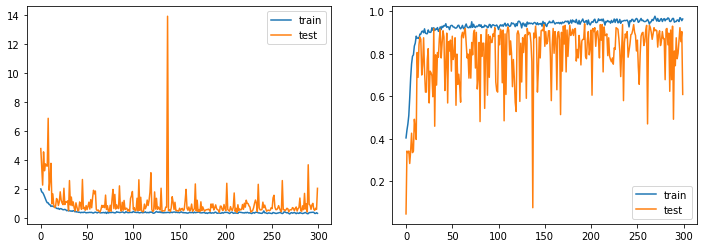

In [13]:
#Plot Loss and Accuracy
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()